In [2]:
%matplotlib widget 
%config InlineBackend.figure_format = 'svg'
%load_ext autoreload
%autoreload 2



import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy
from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
import json
from scipy.fft import fft, fftfreq
import Pyro4.util

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})
plt.rcParams['animation.html'] = 'jshtml'

# Load experiments

In [ ]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

In [ ]:
"""Reopen saved data"""
def prev_data(expt_path, filename=None):
    temp_data_file = expt_path
    if filename is not None: temp_data_file = os.path.join(expt_path, filename)
    print(temp_data_file)
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [ ]:
expt_path=os.path.join(os.getcwd(), 'data', 'data_240617')
# expt_path = 'C:\_Data\LLqub'
print('Data will be stored in', expt_path)

In [ ]:
config_file = 'config_q3diamond_full688and638_reset.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_zcu216.yml'
# config_file = 'config_zcu216_LLStdCandle.yml'
config_path = os.path.join(os.getcwd(), config_file)
print('Config will be', config_path)

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [ ]:
import yaml
print('Using config file', config_file)
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [ ]:
# im = InstrumentManager(ns_address='192.168.14.1') # Chicago lab
# im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab
im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium
# print(im)
print(im.keys())

In [ ]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())

# Definitions

## Single qb experiments

In [ ]:

def find_freq(expt, param, debug=True, save=True): 
    #- Do a first pass with spectro and a second pass with ramsey
    
    # load param
    reps_spectro = param['reps_spectro']
    span_spectro = param['span']
    npts_spectro = param['npts_spectro']
    npts_ramsey = param['npts_ramsey']
    step_ramsey = param['step_ramsey']
    freq_ramsey = param['freq_ramsey']
    reps_ramsey = param['reps_ramsey']
    qubit_i = param['qubit']
    freq_qb = param['freq_qb']
    check_EF = param['check_EF']
    
    # load the spectro 
    
    if freq_qb is None: 
        if check_EF: 
            freq_qb = yaml_cfg.device.qubit.f_ef[qubit_i]
        else:
            freq_qb = yaml_cfg.device.qubit.f_ge[qubit_i]
            
    if check_EF:
        qspec = meas.PulseProbeEFSpectroscopyExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"qubit_EF_spectroscopy_qubit{qubit_i}",
        config_file=config_path,
        )
        
    else:
        qspec = meas.PulseProbeSpectroscopyExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"qubit_spectroscopy_qubit{qubit_i}",
        config_file=config_path,)
        
        
    qspec.cfg = AttrDict(deepcopy(yaml_cfg))
        
    qspec.cfg.expt = dict(
    start=freq_qb - 0.5*span_spectro, # resonator frequency to be mixed up [MHz]
    step=span_spectro/npts_spectro, # min step ~1 Hz
    expts=npts_spectro, # Number of experiments stepping from start
    reps=reps_spectro, # Number of averages per point
    rounds=1, # Number of start to finish sweeps to average over
    length=10, # qubit probe constant pulse length [us]
    gain=25, # qubit pulse gain
    pulse_type='const',
    qubit=qubit_i,
    )
    
        
    # launch the spectro
    qspec.cfg.device.readout.relax_delay = 100 # Wait time between experiments [us]
    if check_EF: 
        qspec.go(analyze=False, display=False, progress=debug, save=False)
        qspec.analyze(fit=True, signs=[1, 1, 1])
        freq_qb = qspec.data['fit_amps'][2]
        print('freq_qb_{}'.format(qubit_i), freq_qb)
        # qspec.display(fit=True, signs=[1, 1, 1])
    else:
        qspec.go(analyze=True, display=debug, progress=debug, save=False)
        p = qspec.data['fit_amps']
        freq_qb = p[2]
        print('freq_qb_{}'.format(qubit_i), freq_qb)
    
    # load ramsey
    
    if check_EF: 
        t2r = meas.RamseyExperiment(
        soccfg=soc,
        path=expt_path,
        prefix="ramseyEF"+f"_qubit{qubit_i}",
        config_file=config_path,)
    else: 
        t2r = meas.RamseyExperiment(
        soccfg=soc,
        path=expt_path,
        prefix="ramsey"+f"_qubit{qubit_i}",
        config_file=config_path,)
        
    
    t2r.cfg = AttrDict(deepcopy(yaml_cfg))
    
    if check_EF:
        t2r.cfg.device.qubit.f_ef[qubit_i] = freq_qb
    else:
        t2r.cfg.device.qubit.f_ge[qubit_i] = freq_qb
     
     
    print('config qubit i', qubit_i)   
    print(t2r.cfg.device)
    
    
    t2r.cfg.expt = dict(
    start=0, # wait time tau [us]
    expts=npts_ramsey, # number of experiments
    step=soc.cycles2us(step_ramsey), # [us] make sure nyquist freq = 
    ramsey_freq=freq_ramsey, # [MHz]
    reps=reps_ramsey, # number of averages
    rounds=4,
    checkZZ=False,
    checkEF=check_EF,
    qubits=[qubit_i])   
    
        
    t2r.go(analyze=True, display=debug, progress=debug, save=False)
    t2r_fit, t2r_fit_err, t2r_adjust = meas.fitting.get_best_fit(t2r.data, get_best_data_params=['f_adjust_ramsey'])      
    print('T2R: %i +/- %i' % (t2r_fit[3], np.sqrt(t2r_fit_err[3][3])))
    
    if save: 
        expt.cfg = t2r.cfg
        expt.data['xpts'].append(t2r.data['xpts'])
        expt.data['avgi'].append(t2r.data['avgi'])
        expt.data['avgq'].append(t2r.data['avgq'])
        expt.data['amps'].append(t2r.data['amps'])
        expt.data['t2r_fit'].append(t2r_fit[3])
        expt.data['t2r_fit_err'].append(np.sqrt(t2r_fit_err[3][3]))
        expt.data['times'].append(time.time()-start_time)
        delta_freq = np.min(np.abs(t2r_adjust))
        expt.data['freq_qb'].append(freq_qb + delta_freq)
        # save data
        expt.save_data()
        
    return freq_qb + delta_freq, t2r_fit[3], np.sqrt(t2r_fit_err[3][3])
            
            
def T1(expt, param, debug=True, save=True): 
    # load param
    reps = param['reps']
    npts = param['npts']
    span = param['span']
    qubit_i = param['qubit']
    freq_qb = param['freq_qb']
    check_EF = param['check_EF']
    gain_pulse = param['gain_pulse']
    
    if freq_qb is None: 
        if check_EF: 
            freq_qb = yaml_cfg.device.qubit.f_ef[qubit_i]
        else:
            freq_qb = yaml_cfg.device.qubit.f_ge[qubit_i]
    
    if check_EF: 
        t1 = meas.T1Experiment(
        soccfg=soc,
        path=expt_path,
        prefix="t1EF"+f"_qubit{qubit_i}",
        config_file=config_path,)
    else: 
        t1 = meas.T1Experiment(
        soccfg=soc,
        path=expt_path,
        prefix="t1"+f"_qubit{qubit_i}",
        config_file=config_path,)
    
    t1.cfg = AttrDict(deepcopy(yaml_cfg))
    if check_EF:
        t1.cfg.device.qubit.f_ef[qubit_i] = freq_qb
        t1.cfg.device.readout.frequency[qubit_i] = t1.cfg.device.readout.frequency_ef[qubit_i]
    else:
        t1.cfg.device.qubit.f_ge[qubit_i] = freq_qb
        

    
    if gain_pulse is not None:
        if check_EF: 
            t1.cfg.device.qubit.pulses.pi_ef.gain[qubit_i] = int(gain_pulse)
        else:
            t1.cfg.device.qubit.pulses.pi_ge.gain[qubit_i] = int(gain_pulse)
    
    
    t1.cfg.expt = dict(start=0, # wait time [us]
                step=span/npts,
                expts=npts,
                reps=reps,
                rounds=10,
                qubit=qubit_i,
                checkEF=check_EF,
            )
    
    t1.go(analyze=True, display=debug, progress=debug, save=False)
    
    t1_fit, t1_fit_err = meas.fitting.get_best_fit(t1.data) #, fitter.expfunc)
    print('T1: %i +/- %i' % (t1_fit[3], np.sqrt(t1_fit_err[3][3]))) 
    
    if save:
        expt.cfg = t1.cfg
        expt.data['xpts'].append(t1.data['xpts'])
        expt.data['avgi'].append(t1.data['avgi'])
        expt.data['avgq'].append(t1.data['avgq'])
        expt.data['amps'].append(t1.data['amps'])
        expt.data['t1_fit'].append(t1_fit[3])
        expt.data['t1_fit_err'].append(np.sqrt(t1_fit_err[3][3]))
        expt.data['times'].append(time.time()-start_time)  
        # save data
        expt.save_data()
        
    return t1_fit[3], np.sqrt(t1_fit_err[3][3])


def pi_pulse(expt, param, debug=True, save=True): 
    
    # load param 
    reps = param['reps']
    npts = param['npts']
    freq_qb = param['freq_qb']
    check_EF = param['check_EF']
    qubit_i = param['qubit']
    
    if freq_qb is None:
        if check_EF: 
            freq_qb = yaml_cfg.device.qubit.f_ef[qubit_i]
        else:
            freq_qb = yaml_cfg.device.qubit.f_ge[qubit_i]
            
    if check_EF:
        amprabi = meas.AmplitudeRabiExperiment(
        soccfg=soc,
        path=expt_path,
        prefix="amp_rabi_EF"+f"_qubit{qubit_i}",
        config_file=config_path,
        )
    
    else: 
        amprabi = meas.AmplitudeRabiExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"amp_rabi_qubit{qubit_i}",
        config_file=config_path,
        )
        
    amprabi.cfg = AttrDict(deepcopy(yaml_cfg))
    if check_EF:
        amprabi.cfg.device.qubit.f_ef[qubit_i] = freq_qb
        gain_max = 1.5*yaml_cfg.device.qubit.pulses.pi_ef.gain[qubit_i]
        pi_len = yaml_cfg.device.qubit.pulses.pi_ef.sigma[qubit_i]
    else:
        amprabi.cfg.device.qubit.f_ge[qubit_i] = freq_qb
        gain_max = 1.5*yaml_cfg.device.qubit.pulses.pi_ge.gain[qubit_i]
        pi_len = yaml_cfg.device.qubit.pulses.pi_ge.sigma[qubit_i]
        
    span = min((32000, gain_max))
    
    amprabi.cfg.expt = dict(
        start=0, # pulse length [ns]
        step=int(span/npts), # step [ns]
        expts=npts, # number of experiments
        reps=reps, # number of averages
        rounds=10, # number of rounds
        sigma_test=pi_len,
        pulse_type='gauss',
        checkZZ=False,
        checkEF=check_EF,
        qubits=[qubit_i])
    
    amprabi.go(analyze=False, display=False, progress=debug, save=False)
    amprabi.analyze(fit=True)
    amprabi_fit, amprabi_fit_err = meas.fitting.get_best_fit(amprabi.data)
    
    p = amprabi_fit
    if p[2] > 180: p[2] = p[2] - 360
    elif p[2] < -180: p[2] = p[2] + 360
    if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
    else: pi_gain = (3/2 - p[2]/180)/2/p[1]
    
    print('Pi pulse gain: %i' % pi_gain)
    if pi_gain > 32000:
        if debug:
            amprabi.display(fit=False)
        print(f'WARNING: Fit pi pulse gain is long ({pi_gain}), please double check!')
        pi_gain = 30000
    else: 
        if debug:
            amprabi.display(fit=True)
            
    if save:
        expt.cfg = amprabi.cfg
        expt.data['xpts'].append(amprabi.data['xpts'])
        expt.data['avgi'].append(amprabi.data['avgi'])
        expt.data['avgq'].append(amprabi.data['avgq'])
        expt.data['amps'].append(amprabi.data['amps'])
        expt.data['times'].append(time.time()-start_time)
        expt.data['pi_gain'].append(pi_gain)
        
    return pi_gain
    

## Two qb experiments 

# Single qubit parameters

## Pulse probe, T1, T2R

### Parameters

In [ ]:
qubits = [0,1,2,3]
max_time = np.inf
wait_time = 0
debug = True
live_plotting = True

spectro_expts = []
t1_expts = []
t2r_expts = []
pi_pulse_eg_expts = []
t1_ef_expts = []
t2r_ef_expts = []
pi_pulse_ef_expts = []

expt = Experiment(config_file=config_path)


# EG parameters

t1_span = [300, 500, 300, 300]
t1_npts = [25]*4
t1_rep = [200, 400, 200, 200]

spectro_rep = [1000, 1000, 1000, 1000]
span_spectro = [10]*4
npts_spectro = [100]*4

t2_ntps = [100]*4
t2_rep = [200, 400, 200, 200]
t2_step = [75, 75, 75, 75]
t2_freq = [0.25]*4

pi_pulse_eg_rep = [100, 100, 100, 100]
pi_pulse_eg_npts = [50]*4

# EF parameters

check_EF = [False, False, True, True]

t1ef_span = [300, 500, 300, 300]
t1ef_npts = [25]*4
t1ef_rep = [200, 400, 200, 200]

spectro_ef_rep = [1000, 1000, 1000, 1000]
span_ef_spectro = [10]*4
npts_ef_spectro = [100]*4

t2ef_ntps = [100]*4
t2ef_rep = [200, 400, 200, 200]
t2ef_step = [75, 75, 75, 75]
t2ef_freq = [0.25]*4

pi_pulse_ef_rep = [100, 100, 100, 100]
pi_pulse_ef_npts = [50]*4


### Setup experiments

In [ ]:

for qubit_i in qubits:
   
    # T1
    expt_t1_sweep = Experiment(
    path=expt_path,
    prefix=f"t1_time_sweep_qubit{qubit_i}",
    config_file=config_path)
    expt_t1_sweep.data = dict(xpts=[], avgi=[], avgq=[], amps=[], t1_fit=[], t1_fit_err=[], times=[]) 
        
    # T2R
    expt_t2r_sweep = Experiment(
    path=expt_path,
    prefix=f"t2r_time_sweep_qubit{qubit_i}",
    config_file=config_path)
    expt_t2r_sweep.data = dict(xpts=[], avgi=[], avgq=[], amps=[], t2r_fit=[], t2r_fit_err=[], times=[], freq_qb=[])

    # pi pulse
    expt_pi_eg = Experiment(
    path=expt_path,
    prefix=f"pi_pulse_qubit{qubit_i}",
    config_file=config_path)
    expt_pi_eg.data = dict(xpts=[], avgi=[], avgq=[], amps=[], times=[], pi_gain=[])
    
    t1_expts.append(expt_t1_sweep)
    t2r_expts.append(expt_t2r_sweep)
    pi_pulse_eg_expts.append(expt_pi_eg)
    
    if check_EF[qubit_i]:
        
        expt_t1_ef_sweep = Experiment(
        path=expt_path,
        prefix=f"t1EF_time_sweep_qubit{qubit_i}",
        config_file=config_path)
        expt_t1_ef_sweep.data = dict(xpts=[], avgi=[], avgq=[], amps=[], t1_fit=[], t1_fit_err=[], times=[])
        
        expt_t2r_ef_sweep = Experiment(
        path=expt_path,
        prefix=f"t2rEF_time_sweep_qubit{qubit_i}",
        config_file=config_path)
        expt_t2r_ef_sweep.data = dict(xpts=[], avgi=[], avgq=[], amps=[], t2r_fit=[], t2r_fit_err=[], times=[], freq_qb=[])

        expt_pi_ef_eg = Experiment(
        path=expt_path,
        prefix=f"pi_pulseEF_qubit{qubit_i}",
        config_file=config_path)
        expt_pi_ef_eg.data = dict(xpts=[], avgi=[], avgq=[], amps=[], times=[], pi_gain=[])
        
        t1_ef_expts.append(expt_t1_ef_sweep)
        t2r_ef_expts.append(expt_t2r_ef_sweep)
        pi_pulse_ef_expts.append(expt_pi_ef_eg)

In [ ]:
# define a list of parameters dictionaries
param_t1 =[]
param_t2r = []
param_pi_eg = []
param_t1_ef = []
param_t2r_ef = []
param_pi_ef = []

time_t1_tab = []
time_t2_tab = []
time_eg_tab = []

time_t1_ef_tab = []
time_t2_ef_tab = []
time_ef_tab = []

t1_tab = []
t1err_tab = []
t2_tab = []
t2err_tab = []
qb_freq_tab = []
pi_eg_gain_tab = []

t1ef_tab = []
t1eferr_tab = []
t2ef_tab = []
t2eferr_tab = []
qb_freq_ef_tab = []
pi_ef_gain_tab = []

for qubit_i in qubits:
    
    _dict_t1 = {'reps': t1_rep[qubit_i], 'npts': t1_npts[qubit_i], 'span': t1_span[qubit_i], 'qubit': qubit_i, 'freq_qb': None, 'check_EF': False}
    _dict_t2 = {'reps_spectro': spectro_rep[qubit_i], 'span': span_spectro[qubit_i], 'npts_spectro': npts_spectro[qubit_i], 'npts_ramsey': t2_ntps[qubit_i], 'step_ramsey': t2_step[qubit_i], 'freq_ramsey': t2_freq[qubit_i], 'reps_ramsey': t2_rep[qubit_i],'qubit': qubit_i, 'freq_qb': None, 'check_EF': False}
    _dict_pi_eg = {'reps': pi_pulse_eg_rep[qubit_i], 'npts': pi_pulse_eg_npts[qubit_i], 'qubit': qubit_i, 'freq_qb': None, 'check_EF': False}
    param_t1.append(_dict_t1)
    param_t2r.append(_dict_t2)
    param_pi_eg.append(_dict_pi_eg)
    
    time_t1_tab.append(np.array([]))
    time_t2_tab.append(np.array([]))
    time_eg_tab.append(np.array([]))
    t1_tab.append(np.array([]))
    t1err_tab.append(np.array([]))
    t2_tab.append(np.array([]))
    t2err_tab.append(np.array([]))
    qb_freq_tab.append(np.array([]))
    pi_eg_gain_tab.append(np.array([]))
    
    
    if check_EF[qubit_i]:
        _dict_t1_ef = {'reps': t1ef_rep[qubit_i], 'npts': t1ef_npts[qubit_i], 'span': t1ef_span[qubit_i], 'qubit': qubit_i, 'freq_qb': None, 'check_EF': True}
        _dict_t2_ef = {'reps_spectro': spectro_ef_rep[qubit_i], 'span': span_ef_spectro[qubit_i], 'npts_spectro': npts_ef_spectro[qubit_i], 'npts_ramsey': t2ef_ntps[qubit_i], 'step_ramsey': t2ef_step[qubit_i], 'freq_ramsey': t2ef_freq[qubit_i],'reps_ramsey':t2ef_rep[qubit_i], 'qubit': qubit_i, 'freq_qb': None, 'check_EF': True}
        _dict_pi_ef = {'reps': pi_pulse_ef_rep[qubit_i], 'npts': pi_pulse_ef_npts[qubit_i], 'qubit': qubit_i, 'freq_qb': None, 'check_EF': True}
        
        param_t1_ef.append(_dict_t1_ef)
        param_t2r_ef.append(_dict_t2_ef)
        param_pi_ef.append(_dict_pi_ef)
        
        
        time_t1_ef_tab.append(np.array([]))
        time_t2_ef_tab.append(np.array([]))
        time_ef_tab.append(np.array([]))
        t1ef_tab.append(np.array([]))
        t1eferr_tab.append(np.array([]))
        t2ef_tab.append(np.array([]))
        t2eferr_tab.append(np.array([]))
        qb_freq_ef_tab.append(np.array([]))
        pi_ef_gain_tab.append(np.array([]))

### Start experiments

In [ ]:
# try live plotting
if live_plotting: 
    fig, ax = plt.subplots(4, 1, figsize=(8, 10), sharex=True)
    ax[3].set_ylabel(r'$\pi$ pulse gain')
    ax[2].set_ylabel('$T_1$ (us)')
    ax[1].set_ylabel('$T_{2R}$ (us)')
    ax[0].set_ylabel('$\delta f$ (MHz)')
    ax[2].set_xlabel('Time (hrs)')
    
    fig2, ax2 = plt.subplots(4, 1, figsize=(8, 10), sharex=True)
    ax2[3].set_ylabel(r'$\pi$ pulse gain')
    ax2[2].set_ylabel('$T_1$ (us)')
    ax2[1].set_ylabel('$T_{2R}$ (us)')
    ax2[0].set_ylabel('$\delta f$ (MHz)')
    ax2[2].set_xlabel('Time (hrs)')
    # set title
    fig.suptitle('Qubit calibration eg')
    fig2.suptitle('Qubit calibration ef')

In [ ]:
start_time = time.time()

try: 

    while time.time()-start_time < max_time:
        idx_ef = 0
        for idxq, qubit_i in enumerate(qubits):
            
            expt_t1_sweep = t1_expts[idxq]
            expt_t2r_sweep = t2r_expts[idxq]
            expt_pi_eg = pi_pulse_eg_expts[idxq]
            
            # ---- T2R -----------
            # try: 
            print('T2')
            print(f'Qubit {qubit_i}')
            freq_qb, t2, t2err = find_freq(expt_t2r_sweep, param_t2r[idxq], debug=debug, save=True)
        
            # check that the frequency is not too far from the initial guess
            # and if the errorbar is too large
            print('len(qb_freq_tab[idxq])', len(qb_freq_tab[idxq]))
            if len(qb_freq_tab[idxq]) > 0:
                f_comp = np.mean(qb_freq_tab[idxq])
            else:
                f_comp = freq_qb
                
            print('f_comp', f_comp)
            print('freq_qb', freq_qb)
                
            if np.abs(freq_qb - f_comp) > 3: 
                print(f'WARNING: Frequency shift is too large ({np.abs(freq_qb - f_comp)}), please double check!')
            elif t2err > 10: 
                print(f'WARNING: T2 error is too large ({t2err}), please double check!')
            else: 
                param_t1[idxq]['freq_qb'] = freq_qb
                param_t2r[idxq]['freq_qb'] = freq_qb
                param_pi_eg[idxq]['freq_qb'] = freq_qb
                time_t2_tab[idxq] = np.append(time_t2_tab[idxq], time.time()-start_time)
                t2_tab[idxq] = np.append(t2_tab[idxq], t2)
                t2err_tab[idxq] = np.append(t2err_tab[idxq], t2err)
                qb_freq_tab[idxq] = np.append(qb_freq_tab[idxq], freq_qb)
                
            if live_plotting: 
                ax[0].clear()
                ax[1].clear()
                for _idxq, _qubit_i in enumerate(qubits):
                    ax[0].errorbar(time_t2_tab[_idxq]/60/60, t2_tab[_idxq], yerr=t2err_tab[_idxq], fmt='o-', elinewidth=0.75, label=f'Qubit {_qubit_i}')
                    if len(qb_freq_tab[_idxq]) > 1:
                        ax[1].plot(time_t2_tab[_idxq]/60/60, qb_freq_tab[_idxq] - np.mean(qb_freq_tab[_idxq]), 'o-', label=f'Qubit {_qubit_i}')
                        ax[1].legend()
                    ax[0].legend()
                    ax[0].set_ylabel('$T_{2R}$ (us)')
                    ax[1].set_ylabel('$\delta f$ (MHz)')
                fig.canvas.draw()
                    
            # except Exception as e:
            #     print('encountered error', e)
            #     continue       
            # ---- pi pulse eg  -----------
            # try:
            print('Pi pulse eg')
            print(f'Qubit {qubit_i}')
            pi_gain = pi_pulse(expt_pi_eg, param_pi_eg[idxq], debug=debug, save=True)
            pi_eg_gain_tab[idxq] = np.append(pi_eg_gain_tab[idxq], pi_gain)
            time_eg_tab[idxq] = np.append(time_eg_tab[idxq], time.time()-start_time)
            
            if live_plotting:
                ax[3].clear()
                for _idxq, _qubit_i in enumerate(qubits):
                    ax[3].plot(time_eg_tab[_idxq]/60/60, pi_eg_gain_tab[_idxq], 'o-', label=f'Qubit {_qubit_i}')
                    ax[3].legend()
                ax[3].set_ylabel(r'$\pi$ pulse gain')
                fig.canvas.draw()
            
            # except Exception as e:
            #     print('encountered error', e)
            #     continue
            # ---- T1 -----------
            try:
                param_t1[idxq]['gain_pulse'] = int(pi_gain)
                print('T1')
                print(f'Qubit {qubit_i}')
                t1, t1err = T1(expt_t1_sweep, param_t1[idxq], debug=debug, save=True)
                time_t1_tab[idxq] = np.append(time_t1_tab[idxq], time.time()-start_time)
                t1_tab[idxq] = np.append(t1_tab[idxq], t1)
                t1err_tab[idxq] = np.append(t1err_tab[idxq], t1err)
                
                if live_plotting: 
                    ax[2].clear()
                    for _idxq, _qubit_i in enumerate(qubits):
                        ax[2].errorbar(time_t1_tab[_idxq]/60/60, t1_tab[_idxq], yerr=t1err_tab[_idxq], fmt='o-',  elinewidth=0.75, label=f'Qubit {_qubit_i}')
                        ax[2].legend()
                        ax[2].set_ylabel('$T_1$ (us)')
                        ax[2].set_xlabel('Time (hrs)')
                    fig.canvas.draw()
                        
            except Exception as e:
                print('encountered error', e)
                continue  
            
### -------------------------------------------------- EF -------------------------------------------- ### 
            if check_EF[qubit_i]:
                
                expt_t1_ef_sweep = t1_ef_expts[idx_ef]
                expt_t2r_ef_sweep = t2r_ef_expts[idx_ef]
                expt_pi_ef_eg = pi_pulse_ef_expts[idx_ef]
                
                # --------T2 EF----------------
                try: 
                    print('T2 EF')
                    print(f'Qubit {qubit_i}')
                    freq_qb, t2, t2err = find_freq(expt_t2r_ef_sweep, param_t2r_ef[idx_ef], debug=debug, save=True)
                    
                    # check that the frequency is not too far from the initial guess
                    # and if the errorbar is too large
                    
                    if len(qb_freq_ef_tab[idx_ef]) > 0:
                        f_comp = np.mean(qb_freq_ef_tab[idx_ef])
                    else:
                        f_comp = freq_qb
                    
                    if np.abs(freq_qb - f_comp) > 3: 
                        print(f'WARNING: Frequency shift is too large ({np.abs(freq_qb - f_comp)}), please double check!')
                    elif t2err > 20: 
                        print(f'WARNING: T2 error is too large ({t2err}), please double check!')
                    else:
                        param_t1_ef[idx_ef]['freq_qb'] = freq_qb
                        param_t2r_ef[idx_ef]['freq_qb'] = freq_qb
                        param_pi_ef[idx_ef]['freq_qb'] = freq_qb
                        time_t2_ef_tab[idx_ef] = np.append(time_t2_ef_tab[idx_ef], time.time()-start_time)
                        t2ef_tab[idx_ef] = np.append(t2ef_tab[idx_ef], t2)
                        t2eferr_tab[idx_ef] = np.append(t2eferr_tab[idx_ef], t2err)
                        qb_freq_ef_tab[idx_ef] = np.append(qb_freq_ef_tab[idx_ef], freq_qb)
                            
                    if live_plotting: 
                        ax2[0].clear()
                        ax2[1].clear()
                        _idx_ef = 0
                        for _idxq, _qubit_i in enumerate(qubits):
                            if check_EF[_qubit_i]:
                                ax2[0].errorbar(time_t2_ef_tab[_idx_ef]/60/60, t2ef_tab[_idx_ef], yerr=t2eferr_tab[_idx_ef], fmt='o-', elinewidth=0.75, label=f'Qubit {_qubit_i}')
                                if len(qb_freq_ef_tab[_idx_ef]) > 1:
                                    ax2[1].plot(time_t2_ef_tab[_idx_ef]/60/60, qb_freq_ef_tab[_idx_ef] - np.mean(qb_freq_ef_tab[_idx_ef]), 'o-', label=f'Qubit {_qubit_i}')
                                    ax2[1].legend()
                                ax2[0].legend()
                                ax2[0].set_ylabel('T2R (us)')
                                ax2[1].set_ylabel('Frequency shift (MHz)')
                                _idx_ef += 1
                            fig2.canvas.draw()
                                                    

                except Exception as e:
                    print('encountered error', e)
                # ----pi pulse EF -------------
                try:
                        
                    print('Pi pulse EF')
                    print(f'Qubit {qubit_i}')
                    pi_gain = pi_pulse(expt_pi_ef_eg, param_pi_ef[idx_ef], debug=debug, save=True)
                    
                    pi_ef_gain_tab[idx_ef] = np.append(pi_ef_gain_tab[idx_ef], pi_gain)
                    time_ef_tab[idx_ef] = np.append(time_ef_tab[idx_ef], time.time()-start_time)
                    
        
                    
                    if live_plotting: 
                        _idx_ef = 0
                        ax2[3].clear()
                        for _idxq, _qubit_i in enumerate(qubits):
                            if check_EF[_qubit_i]:
                                ax2[3].plot(time_ef_tab[_idx_ef]/60/60, pi_ef_gain_tab[_idx_ef], 'o-', label=f'Qubit {_qubit_i} EF')
                                ax2[3].legend()
                                ax2[3].set_ylabel(r'$\pi$ pulse gain')
                                _idx_ef += 1
                        fig2.canvas.draw()   

                except Exception as e:
                    print('encountered error', e)
                # -------T1 EF ----------------
                try:
                    param_t1_ef[idx_ef]['gain_pulse'] = int(pi_gain)
                    print('T1 EF')
                    print(f'Qubit {qubit_i}')
                    t1, t1err = T1(expt_t1_ef_sweep, param_t1_ef[idx_ef], debug=debug, save=True)
                    time_t1_ef_tab[idx_ef] = np.append(time_t1_ef_tab[idx_ef], time.time()-start_time)
                    t1ef_tab[idx_ef] = np.append(t1ef_tab[idx_ef], t1)
                    t1eferr_tab[idx_ef] = np.append(t1eferr_tab[idx_ef], t1err)
                    
                    if live_plotting: 
                        ax2[2].clear()
                        _idx_ef = 0
                        for _idxq, _qubit_i in enumerate(qubits):
                            if check_EF[_qubit_i]:
                                ax2[2].errorbar(time_t1_ef_tab[_idx_ef]/60/60, t1ef_tab[_idx_ef], yerr=t1eferr_tab[_idx_ef], fmt='o-',  elinewidth=0.75, label=f'Qubit {_qubit_i} EF')
                                ax2[2].legend()
                                ax2[2].set_ylabel('$T_1$ (us)')
                                ax2[2].set_xlabel('Time (hrs)')
                                _idx_ef += 1
                            fig2.canvas.draw()
                        
                except Exception as e:
                    print('encountered error', e)
                    continue
                
                idx_ef += 1
                
except KeyboardInterrupt as err:
    print(f'caught KeyboardInterrupt, stopping after {(time.time()-start_time)/60/60} hours')
    
    # print the last measured parameters and the yaml config
    
    print('--------------- yaml config parameters -------------:')  
    print('Qubit eg frequencies', yaml_cfg.device.qubit.f_ge)
    print('Qubit ef frequencies', yaml_cfg.device.qubit.f_ef)
    print('Qubit pi eg gains', yaml_cfg.device.qubit.pulses.pi_ge.gain)
    print('Qubit pi ef gains', yaml_cfg.device.qubit.pulses.pi_ef.gain)
    print(' --------------- last measured parameters ---------------')
    print('Qubit eg frequencies', [qb_freq_tab[i][-1] for i in range(len(qb_freq_tab))])
    print('Qubit ef frequencies', [qb_freq_ef_tab[i][-1] for i in range(len(qb_freq_ef_tab))])
    print('Qubit pi eg gains', [pi_eg_gain_tab[i][-1] for i in range(len(pi_eg_gain_tab))])
    print('Qubit pi ef gains', [pi_ef_gain_tab[i][-1] for i in range(len(pi_ef_gain_tab))])

In [ ]:
print('Qubit eg frequencies', [qb_freq_tab[i] for i in range(len(qb_freq_tab))])
print('Qubit ef frequencies', [qb_freq_ef_tab[i] for i in range(len(qb_freq_ef_tab))])
print('Qubit pi eg gains', [pi_eg_gain_tab[i] for i in range(len(pi_eg_gain_tab))])
print('Qubit pi ef gains', [pi_ef_gain_tab[i] for i in range(len(pi_ef_gain_tab))])


### Display

In [ ]:
# qubits = [0,1,2,3]
qubits = [0, 1, 2, 3]
file_name_qubit = ['00040', '00050', '00028', '00029']
# file_name_qubit = ['00001', '00003', '00001']

t1_tab = []
t1err_tab = []
time_t1_tab = []
t2_tab = []
t2err_tab = []
time_t2_tab = []
qb_freq = []
for idxq, qubit_i in enumerate(qubits):
    
    print('qubit', qubit_i)
    
    fname_t1 = file_name_qubit[qubit_i] + f'_t1_time_sweep_qubit{qubit_i}.h5'
    fname_t2 = file_name_qubit[qubit_i] + f'_t2r_time_sweep_qubit{qubit_i}.h5'

    expt_t1_sweep = Experiment(config_file=config_path)
    temp_data, attrs = prev_data(expt_path, fname_t1)
    expt_t1_sweep.cfg = AttrDict(attrs['config'])
    expt_t1_sweep.data = temp_data

    expt_t2r_sweep = Experiment(config_file=config_path)
    temp_data, attrs = prev_data(expt_path, fname_t2)
    expt_t2r_sweep.cfg = AttrDict(attrs['config'])
    expt_t2r_sweep.data = temp_data
    
    time_t1 = np.asarray(expt_t1_sweep.data['times'])
    t1_fit = np.asarray(expt_t1_sweep.data['t1_fit'])
    t1_fit_err = np.asarray(expt_t1_sweep.data['t1_fit_err'])


    time_t2r = np.asarray(expt_t2r_sweep.data['times'])
    t2r_fit = np.asarray(expt_t2r_sweep.data['t2r_fit'])
    t2r_fit_err = np.asarray(expt_t2r_sweep.data['t2r_fit_err'])
    freq_qb = np.asarray(expt_t2r_sweep.data['freq_qb'])   
    
    t1_err_bounds = [0.01, 20]
    t2r_err_bounds = [0.01, 20]
    
    idx_remove_t1 = np.where((t1_fit_err < t1_err_bounds[0]) | (t1_fit_err > t1_err_bounds[1]))[0]
    idx_remove_t2r = np.where((t2r_fit_err < t2r_err_bounds[0]) | (t2r_fit_err > t2r_err_bounds[1]))[0]
    

    time_t1 = np.delete(time_t1, idx_remove_t1)
    t1_fit = np.delete(t1_fit, idx_remove_t1)
    t1_fit_err = np.delete(t1_fit_err, idx_remove_t1)

    time_t2r = np.delete(time_t2r, idx_remove_t2r)
    t2r_fit = np.delete(t2r_fit, idx_remove_t2r)
    t2r_fit_err = np.delete(t2r_fit_err, idx_remove_t2r)
    freq_qb = np.delete(freq_qb, idx_remove_t2r)
    
        
    
    t1_tab.append(t1_fit)
    t1err_tab.append(t1_fit_err)
    time_t1_tab.append(time_t1)
    
    t2_tab.append(t2r_fit)
    t2err_tab.append(t2r_fit_err)
    time_t2_tab.append(time_t2r)
    
    qb_freq.append(freq_qb)
    
    


In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

for idxq, qubit_i in enumerate(qubits):

    ax[0].errorbar(time_t1_tab[idxq]/60/60, t1_tab[idxq], yerr=t1err_tab[idxq], fmt='o-',  elinewidth=0.75, label=f'Qubit {qubit_i}')
    ax[0].set_ylabel('T1 (us)')
    ax[0].set_xlabel('Time (hrs)')

    ax[1].errorbar(time_t2_tab[idxq]/60/60, t2_tab[idxq], yerr=t2err_tab[idxq], fmt='o-', elinewidth=0.75, label=f'Qubit {qubit_i}')
    ax[1].set_ylabel('T2R (us)')
    ax[1].set_xlabel('Time (hrs)')

    ax[2].plot(time_t2_tab[idxq]/60/60, qb_freq[idxq] - np.mean(qb_freq[idxq]), 'o-', label=f'Qubit {qubit_i}')
    ax[2].set_ylabel('Frequency shift (MHz)')
    ax[2].set_xlabel('Time (hrs)')

ax[0].legend()


# 2Q SWAP

For a given pulse amplitude: rabi vs freq (get opt sideband freq) -> rabi vs time (get opt pi pulse time + population) -> single shot fidelity after swap + ef pulse

### SWAP parameters

In [ ]:
# qubits_swap = [[2, 1]]
qubits_swap = [[2, 1], [3, 1]]
signs = [1, -1]

max_time = 10
wait_time = 0
debug = True 

expt = Experiment(config_file=config_path)

pi_pulse_time = [yaml_cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qubits_swap[0][0]],
                yaml_cfg.device.qubit.pulses.pi_EgGf_Q.sigma[qubits_swap[1][0]]]

span_f = [20]*len(qubits_swap)
npts_f = [40]*len(qubits_swap)
reps_f = [100]*len(qubits_swap)
loops_f = [4]*len(qubits_swap)
init_state = ['|0>|1>', '|1>|1>']


start_len = [0]*len(qubits_swap)
npts_len = [40]*len(qubits_swap)
reps_len = [1000]*len(qubits_swap)


In [ ]:
expt_rabi_freq = []
exp_rabi_time = []

In [ ]:
for idxq, qubits in enumerate(qubits_swap):
    print('qubits', qubits)
    
    _expt_rabi_freq = Experiment(
    path=expt_path,
    prefix=f"rabi_EgGf_freq_sweep_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path)
    _expt_rabi_freq.data = dict(freqpts=[], amps_q1=[], amps_q2=[], times=[], freq_swap=[])
    expt_rabi_freq.append(_expt_rabi_freq)
   
    _expt_rabi_time = Experiment(
    path=expt_path,
    prefix=f"rabi_EgGf_time_sweep_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path)
    _expt_rabi_time.data = dict(timepts=[], amps_q1=[], amps_q2=[], times=[], time_swap=[])
    exp_rabi_time.append(_expt_rabi_time)

In [ ]:
def rabiEgGf_freq_sweep(expt, qubits, start_len, span_f, npts_f, reps_f, loops_f, init_state, sign, debug=False, save=True, fit=False, freq=None):
    
    rabiEgGfFreqLenChevron = meas.EgGfFreqLenChevronExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"rabi_EgGf_freqlen_chevron_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path)
    
    print('freq', freq)
    
    if freq is None:
        freq = rabiEgGfFreqLenChevron.cfg.device.qubit.f_EgGf_Q[qubits[0]]
    
    print('freq', freq)
    
    rabiEgGfFreqLenChevron.cfg.expt = dict(
        start_f=freq - 0.5*_span_f, # start freq [MHz],
        step_f=span_f/npts_f, # freq step, 
        expts_f=npts_f+1, # number of different freq experiments, 
        start_len=start_len, # pulse length (sigma) [us]
        step_len=1, # [us]
        expts_len=1,
        reps=reps_f,
        loops=loops_f,
        pulse_type='flat_top',
        post_process=None, #'threshold',
        measure_f=None,
        init_state=init_state,
        qDrive=qubits[0],
        qubits=qubits,
        measure_qubits=qubits)
    
    rabiEgGfFreqLenChevron.go(analyze=False, display=False, progress=True, save=False)
    
    data = rabiEgGfFreqLenChevron.analyze(data=None, fit=False)
    
    if fit: 
        freqpts = data['freqpts']
        amps_q1 = data['amps'][0].flatten()
        amps_q2 = data['amps'][1].flatten()
            
        # fit data with a second order polynomial
        popt1, pcov1 = meas.fitting.fitquadratic(freqpts, amps_q1)
        popt2, pcov2 = meas.fitting.fitquadratic(freqpts, amps_q2)
        
        freq_opt = np.average([popt1[0], popt2[0]])
        
    else: 
        freqpts = data['freqpts']
        amps_q1 = data['amps'][0].flatten()
        amps_q2 = data['amps'][1].flatten()
        idx_max_q1 = np.argmax(sign[0]*amps_q1)
        idx_max_q2 = np.argmax(sign[1]*amps_q2)
        freq_opt = np.average([freqpts[idx_max_q1], freqpts[idx_max_q2]])
        
    
    if debug: 
        fig, ax = plt.subplots(2, 1, figsize=(5, 5), sharex=True)
        ax[0].plot(freqpts, amps_q1, 'o-', label='Qubit 1')
        if fit: 
            ax[0].plot(freqpts, meas.fitting.quadraticfunc(freqpts, *popt1), label='fit')
        ax[0].set_ylabel('Amplitude')
        ax[0].legend()
        # add vertical line at optimal frequency
        ax[0].axvline(freq_opt, color='black', linestyle='--')
        
        ax[1].plot(freqpts, amps_q2, 'o-', label='Qubit 2')
        if fit:
            ax[1].plot(freqpts, meas.fitting.quadraticfunc(freqpts, *popt2), label='fit')
        ax[1].set_ylabel('Amplitude')
        ax[1].legend()
        # add vertical line at optimal frequency
        ax[1].axvline(freq_opt, color='black', linestyle='--')
        
    if save: 
        expt.cfg = rabiEgGfFreqLenChevron.cfg
        expt.data['freqpts'].append(freqpts)
        expt.data['amps_q1'].append(amps_q1)
        expt.data['amps_q2'].append(amps_q2)
        expt.data['times'].append(time.time()-start_time)
        expt.data['freq_swap'].append(freq_opt)
            
        expt.save_data()
    
    return freq_opt


def rabiEgGf_time_sweep(expt, qubits, start_len, span_len, npts_len, reps_len, init_state, debug=False, save=True, freq=None):
    
    lengthrabiEgGf = meas.LengthRabiEgGfExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"length_rabi_EgGf_qubit{qubits[0]}{qubits[1]}",
    config_file=config_path,
    )
    
    
    lengthrabiEgGf.cfg = AttrDict(deepcopy(yaml_cfg))

    if freq is not None:
        lengthrabiEgGf.cfg.device.qubit.f_EgGf_Q[qubits[0]] = freq_opt
    
    lengthrabiEgGf.cfg.expt = dict(
        start = start_len,
        step = span_len/npts_len,
        expts = npts_len,
        reps = reps_len,
        pulse_type = 'flat_top',
        post_process = 'threshold', 
        singleshot_reps=10000, 
        measure_f=[qubits[0]], 
        init_state=init_state,
        qDrive=qubits[0],
        qubits=qubits,
        measure_qubits=qubits, 
        cool_qubits=[0, 1])
    
    lengthrabiEgGf.go(analyze=True, display=debug, progress=True, save=False)      
    qnames = ['A', 'B']      
    p = lengthrabiEgGf.data[f'fit{qnames[1]}_avgi']
    fit_pi_pulse_time = (3/2 - p[2]/180)/2/p[1]
    
    if save: 
        expt.cfg = lengthrabiEgGf.cfg
        expt.data['timepts'].append(lengthrabiEgGf.data['xpts'])
        expt.data['amps_q1'].append(lengthrabiEgGf.data['avgi'])
        expt.data['amps_q2'].append(lengthrabiEgGf.data['avgq'])
        expt.data['times'].append(time.time()-start_time)
        expt.data['time_swap'].append(fit_pi_pulse_time)
            
        expt.save_data()
    
    
def rabiEF
    


In [ ]:
start_time = time.time()

while time.time() - start_time < max_time:

    for idxq, qubits in enumerate(qubits_swap):
        
        # start with the EF state
        # --- rabi freq sweep
        # first fast scan 
        
        expt_freq = expt_rabi_freq[idxq]
        _span_f = span_f[idxq]
        _npts_f = npts_f[idxq]
        start_len = pi_pulse_time[idxq]
        
        try: 
            freq_opt = rabiEgGf_freq_sweep(expt_freq, qubits, start_len, _span_f, _npts_f,
                                           reps_f[idxq], loops_f[idxq], init_state[idxq],sign=signs,
                                           debug=debug, save=False, fit=False, freq=None)
            print('freq_opt first', freq_opt)
            
        except KeyboardInterrupt as err:
            print(f'caught KeyboardInterrupt, stopping after {len(expt.data["times"])} iterations')
            break
        except Exception as e:
            print('encountered error', e)
            continue
        
        # second precise scan
        
        _span_f = _span_f/10 
        _npts_f = _npts_f//2
        
        try: 

            freq_opt = rabiEgGf_freq_sweep(expt_freq, qubits, start_len, _span_f, _npts_f,
                                            reps_f[idxq], loops_f[idxq], init_state[idxq],sign=signs,
                                            debug=debug, save=True, fit=True, freq=freq_opt)
            print('freq_opt second', freq_opt)
            
        except KeyboardInterrupt as err:
            print(f'caught KeyboardInterrupt, stopping after {len(expt.data["times"])} iterations')
            break
        except Exception as e:
            print('encountered error', e)
            continue
            
        # ---- rabi time sweep
        # first fast scan
        
        expt_time = exp_rabi_time[idxq]
        _span_len = pi_pulse_time[idxq]*1.5
        _npts_len = npts_len[idxq]
        _reps_len = reps_len[idxq]
        start_len = 0
        
        try: 
            time_opt = rabiEgGf_time_sweep(expt_time, qubits, start_len, _span_len, _npts_len, _reps_len, init_state[idxq], debug=debug, save=False, freq=freq_opt)
            print('time_opt', time_opt)
        except KeyboardInterrupt as err:
            print(f'caught KeyboardInterrupt, stopping after {len(expt.data["times"])} iterations')
            break
        except Exception as e:
            print('encountered error', e)
            continue
        
        # second precise scan
        
        start_len = 0.95*time_opt
        _span_len = 0.1*time_opt
        
        try:
            time_opt = rabiEgGf_time_sweep(expt_time, qubits, start_len, _span_len, _npts_len, _reps_len, init_state[idxq], debug=debug, save=True, freq=freq_opt)
            print('time_opt', time_opt)
            
        except KeyboardInterrupt as err:
            print(f'caught KeyboardInterrupt, stopping after {len(expt.data["times"])} iterations')
            break
        except Exception as e:
            print('encountered error', e)
            continue
        
        

# Try liveplotting

In [270]:
param = {}
qubit_watched = [0, 1, 2, 3]
check_EF = [False, False, True, True]
for idx, qubit in enumerate(qubit_watched):
    
    # add qb param to the dict
    _param = {qubit: {}}
    param.update(_param)    
    param[qubit]['t1'] = {}
    param[qubit]['t2'] = {}
    param[qubit]['pi'] = {}
    param[qubit]['t1']['ge'] = {}
    if check_EF[qubit]:
        param[qubit]['t1']['ef'] = {}
    param[qubit]['t2']['ge'] = {}
    if check_EF[qubit]:
        param[qubit]['t2']['ef'] = {}
    param[qubit]['pi']['ge'] = {}
    if check_EF[qubit]:
        param[qubit]['pi']['ef'] = {}
        
    # param[qubit]['zz'] = {}
    # param[qubit]['zz']['spectro'] = {}
    # param[qubit]['zz']['ramsey'] = {}
    # param[qubit]['zz']['pi'] = {}
    # param[qubit]['zz']['spectro']['ge'] = {}
    # if check_EF[qubit]:
    #     param[qubit]['zz']['spectro']['ef'] = {}
    # param[qubit]['zz']['ramsey']['ge'] = {}
    # if check_EF[qubit]:
    #     param[qubit]['zz']['ramsey']['ef'] = {}
    # param[qubit]['zz']['pi']['ge'] = {}
    # if check_EF[qubit]:
    #     param[qubit]['zz']['pi']['ef'] = {}
        
    # param[qubit]['temp'] = {}
    
# param[1]['t2']['ge']['ramsey_round'] = 8
    
    
from Monitoring import Monitoring
mono = Monitoring(param_dict=param, live_plot=False)

Qubit 0
{'reps_spectro': 100, 'span_spectro': 10, 'npts_spectro': 100, 'rounds_spectro': 10, 'probe_length': 5, 'probe_gain': 50, 'reps_ramsey': 200, 'step_ramsey': 75, 'npts_ramsey': 100, 'freq_ramsey': 0.25, 'ramsey_round': 4, 'gain_pulse': None, 'freq_qb': 4110.426312263619, 'freq_qb_err': 0.0002175437218471974, 'value': 29.491505259369923, 'value_err': 1.1400140083780046, 'stored': [], 'stored_err': [], 'freq_stored': [], 'freq_err_stored': [], 'time': [], 'pi_gain': 1970}
qspec.cfg.expt {'start': 4105.426312263619, 'step': 0.1, 'expts': 100, 'reps': 100, 'rounds': 10, 'length': 5, 'gain': 50, 'pulse_type': 'const', 'qubit': 0}


  0%|          | 0/10 [00:00<?, ?it/s]

best 1 0.0562969656533947
Qubit test 0
freq_qb 4110.379389986687 +/- 0.003766229767045272


  0%|          | 0/4 [00:00<?, ?it/s]

best 0 0.12537037764389533
T2R: 2 +/- 0


  0%|          | 0/4 [00:00<?, ?it/s]

best 2 0.021525339035760628
T2R: 17 +/- 0
4110.43109078821 0.0004525069994465377 17.572790088920517 0.8341105102936318


  0%|          | 0/10 [00:00<?, ?it/s]

best 0 0.010517145717076883
pi pulse gain: 1964


  0%|          | 0/10 [00:00<?, ?it/s]

best 1 190162.7623477326
T1: 47 +/- 3
Qubit 1
{'reps_spectro': 100, 'span_spectro': 10, 'npts_spectro': 100, 'rounds_spectro': 10, 'probe_length': 5, 'probe_gain': 50, 'reps_ramsey': 200, 'step_ramsey': 75, 'npts_ramsey': 100, 'freq_ramsey': 0.25, 'ramsey_round': 4, 'gain_pulse': None, 'freq_qb': None, 'freq_qb_err': None, 'value': None, 'value_err': None, 'stored': [], 'stored_err': [], 'freq_stored': [], 'freq_err_stored': [], 'time': []}
qspec.cfg.expt {'start': 3443.2060084405134, 'step': 0.1, 'expts': 100, 'reps': 100, 'rounds': 10, 'length': 5, 'gain': 50, 'pulse_type': 'const', 'qubit': 1}


  0%|          | 0/10 [00:00<?, ?it/s]

best 0 0.0355515294049957
Qubit test 1
freq_qb 3448.208186791307 +/- 0.00017407983677340344


  0%|          | 0/4 [00:00<?, ?it/s]

best 0 0.022637156554894858
T2R: 21492748 +/- 0


  0%|          | 0/4 [00:00<?, ?it/s]

best 2 0.196694840499388
T2R: 15 +/- 7
3448.326110138632 0.004334769250286827 15.485491071428575 7.0364505241534925


  0%|          | 0/10 [00:00<?, ?it/s]

best 0 0.01287870954595022
pi pulse gain: 2600


  0%|          | 0/10 [00:00<?, ?it/s]

best 1 162910.282204009
T1: 116 +/- 6
Qubit 2
{'reps_spectro': 100, 'span_spectro': 10, 'npts_spectro': 100, 'rounds_spectro': 10, 'probe_length': 5, 'probe_gain': 50, 'reps_ramsey': 200, 'step_ramsey': 75, 'npts_ramsey': 100, 'freq_ramsey': 0.25, 'ramsey_round': 4, 'gain_pulse': None, 'freq_qb': None, 'freq_qb_err': None, 'value': None, 'value_err': None, 'stored': [], 'stored_err': [], 'freq_stored': [], 'freq_err_stored': [], 'time': []}
qspec.cfg.expt {'start': 4757.195276919517, 'step': 0.1, 'expts': 100, 'reps': 100, 'rounds': 10, 'length': 5, 'gain': 50, 'pulse_type': 'const', 'qubit': 2}


  0%|          | 0/10 [00:00<?, ?it/s]

best 1 0.06904850764374564
Qubit test 2
freq_qb 4762.126009620412 +/- 0.0018487995110698858


  0%|          | 0/4 [00:00<?, ?it/s]

best 0 0.10809326310707941
T2R: 2 +/- 0


  0%|          | 0/4 [00:00<?, ?it/s]

best 1 0.014874893528169227
T2R: 62 +/- 2
4762.221535978879 0.00011429712494613457 62.863213210573015 2.808567338227819
{'reps_spectro': 100, 'span_spectro': 10, 'npts_spectro': 100, 'rounds_spectro': 10, 'probe_length': 5, 'probe_gain': 50, 'reps_ramsey': 200, 'step_ramsey': 75, 'npts_ramsey': 100, 'freq_ramsey': 0.25, 'ramsey_round': 4, 'gain_pulse': None, 'freq_qb': None, 'freq_qb_err': None, 'value': None, 'value_err': None, 'stored': [], 'stored_err': [], 'freq_stored': [], 'freq_err_stored': [], 'time': []}
spectro EF
qspec.cfg.expt {'start': 4567.401303477017, 'step': 0.1, 'expts': 100, 'reps': 100, 'rounds': 10, 'length': 5, 'gain': 50, 'pulse_type': 'const', 'qubit': 2}


  0%|          | 0/10 [00:00<?, ?it/s]

best 1 0.0393652926338883
Qubit test 2
freq_qb 4572.375862552841 +/- 0.00022036777743587307


  0%|          | 0/4 [00:00<?, ?it/s]

best 2 0.1470034523981693
T2R: 3 +/- 1


  0%|          | 0/4 [00:00<?, ?it/s]

best 1 0.03574557802103358
T2R: 29 +/- 2


  0%|          | 0/10 [00:00<?, ?it/s]

best 0 0.006174552697747826
pi pulse gain: 13598


  0%|          | 0/10 [00:00<?, ?it/s]

best 0 0.007912543692206252
pi pulse gain: 9508


  0%|          | 0/10 [00:00<?, ?it/s]

best 1 137382.77183636843
T1: 61 +/- 1


  0%|          | 0/10 [00:00<?, ?it/s]

 s:\Connie\experiments\qramLL_4QR2\experiments\fitting.py: 68

best 0 164848.20998303758
T1: 32 +/- 1
Qubit 3
{'reps_spectro': 100, 'span_spectro': 10, 'npts_spectro': 100, 'rounds_spectro': 10, 'probe_length': 5, 'probe_gain': 50, 'reps_ramsey': 200, 'step_ramsey': 75, 'npts_ramsey': 100, 'freq_ramsey': 0.25, 'ramsey_round': 4, 'gain_pulse': None, 'freq_qb': None, 'freq_qb_err': None, 'value': None, 'value_err': None, 'stored': [], 'stored_err': [], 'freq_stored': [], 'freq_err_stored': [], 'time': []}
qspec.cfg.expt {'start': 4376.764669681876, 'step': 0.1, 'expts': 100, 'reps': 100, 'rounds': 10, 'length': 5, 'gain': 50, 'pulse_type': 'const', 'qubit': 3}


  0%|          | 0/10 [00:00<?, ?it/s]

best 1 0.13500382296069502
Qubit test 3
freq_qb 4381.525220853785 +/- 0.03623234854942781


  0%|          | 0/4 [00:00<?, ?it/s]

best 2 0.02252930630927536
T2R: 1580213 +/- 0


  0%|          | 0/4 [00:00<?, ?it/s]

best 2 0.018225274689705258
T2R: 37 +/- 1
4381.728586543174 0.0002079493761523843 37.311286390699934 1.5565302536434964
{'reps_spectro': 100, 'span_spectro': 10, 'npts_spectro': 100, 'rounds_spectro': 10, 'probe_length': 5, 'probe_gain': 50, 'reps_ramsey': 200, 'step_ramsey': 75, 'npts_ramsey': 100, 'freq_ramsey': 0.25, 'ramsey_round': 4, 'gain_pulse': None, 'freq_qb': None, 'freq_qb_err': None, 'value': None, 'value_err': None, 'stored': [], 'stored_err': [], 'freq_stored': [], 'freq_err_stored': [], 'time': []}
spectro EF
qspec.cfg.expt {'start': 4205.01094492826, 'step': 0.1, 'expts': 100, 'reps': 100, 'rounds': 10, 'length': 5, 'gain': 50, 'pulse_type': 'const', 'qubit': 3}


  0%|          | 0/10 [00:00<?, ?it/s]

best 0 0.11181434648203678
Qubit test 3
freq_qb 4210.010265855999 +/- 0.029854830144572533


  0%|          | 0/4 [00:00<?, ?it/s]

best 0 0.16563814753569986
T2R: 4 +/- 2


  0%|          | 0/4 [00:00<?, ?it/s]

best 2 0.05349954524655916
T2R: 15 +/- 1


  0%|          | 0/10 [00:00<?, ?it/s]

best 0 0.014555255357329466
pi pulse gain: 1199


  0%|          | 0/10 [00:00<?, ?it/s]

best 0 0.008364278202242763
pi pulse gain: 1567


  0%|          | 0/10 [00:00<?, ?it/s]

best 0 136119.2796440989
T1: 53 +/- 3


  0%|          | 0/10 [00:00<?, ?it/s]

best 1 98647.56293528114
T1: 26 +/- 1
-------------- measured parameters -----------------:
Qubit t1_ge: [[47.83665520406247, 116.09894499739151, 61.66369187191956, 53.481492548613964], [3.2632275875200407, 6.838601203315892, 1.5856648848731765, 3.149899201494759]]
Qubit t2_ge: [[17.572790088920517, 15.485491071428575, 62.863213210573015, 37.311286390699934], [0.8341105102936318, 7.0364505241534925, 2.808567338227819, 1.5565302536434964]]
Qubit t1_ef: [[None, None, 32.55767751048429, 26.599695908393247], [None, None, 1.9178722275672258, 1.6885639009833908]]
Qubit pi_ge: [[1964, 2600, 13598, 1199], [None, None, None, None]]
Qubit pi_ef: [[None, None, 9508, 1567], [None, None, None, None]]
Qubit freq_ef: [[None, None, 4572.488024137958, 4210.137019712715], [None, None, 0.003302749343782253, 0.0026335268000339277]]
Qubit freq_ge: [[4110.43109078821, 3448.326110138632, 4762.221535978879, 4381.728586543174], [0.0004525069994465377, 0.004334769250286827, 0.00011429712494613457, 0.00020794937

 c:\Users\slab\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py: 833

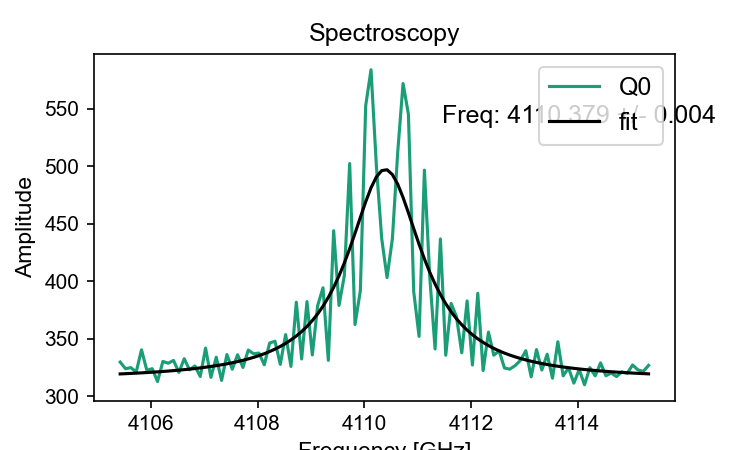

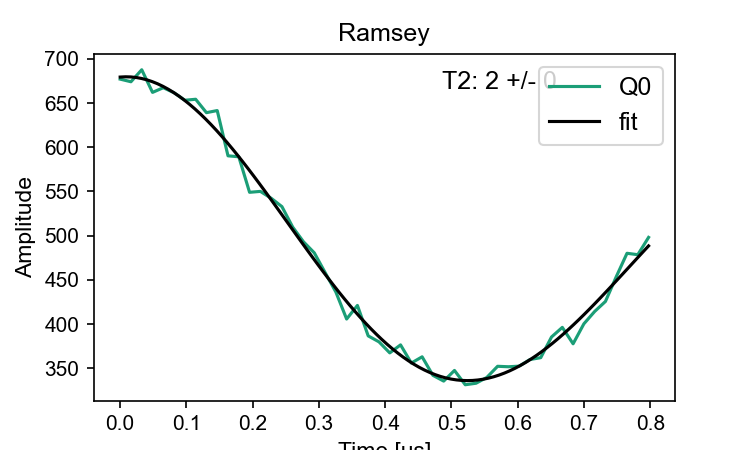

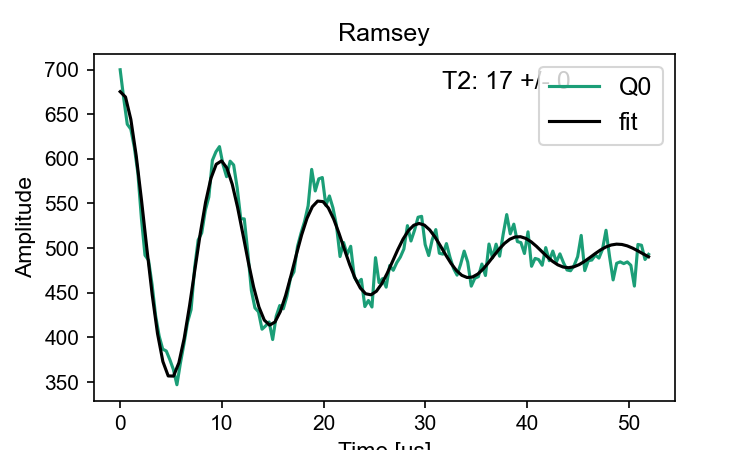

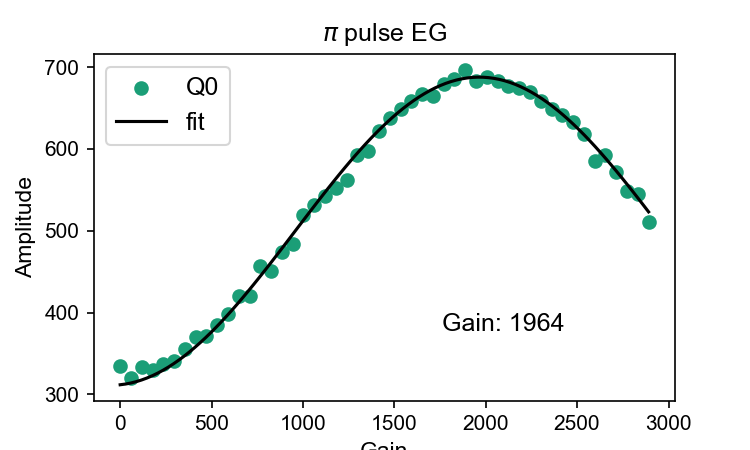

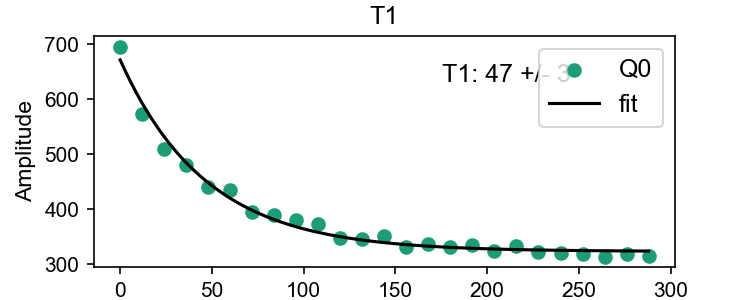

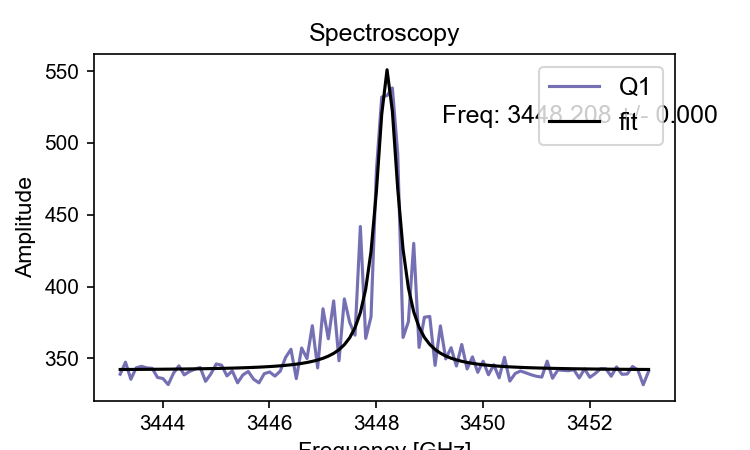

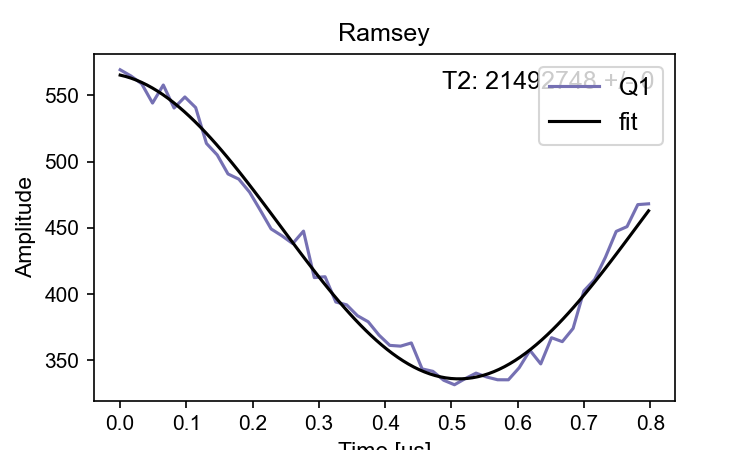

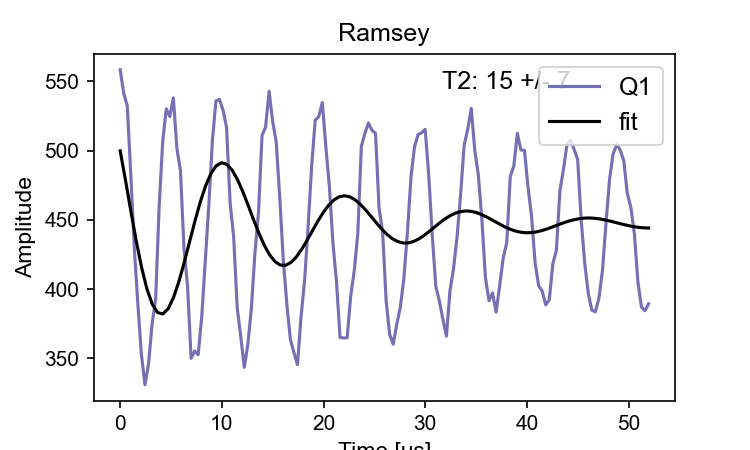

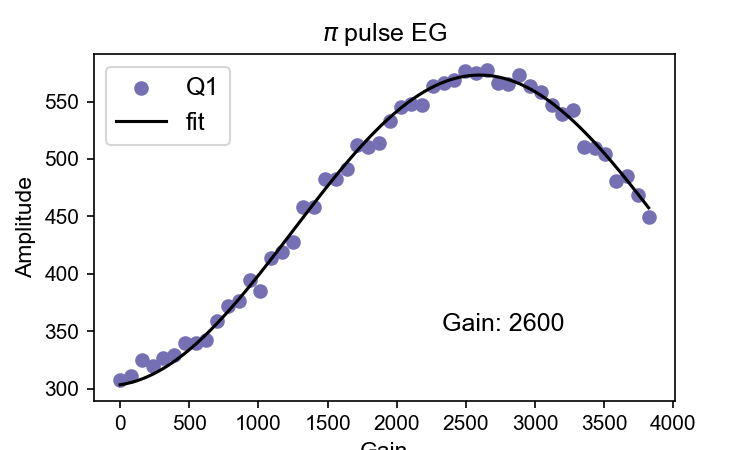

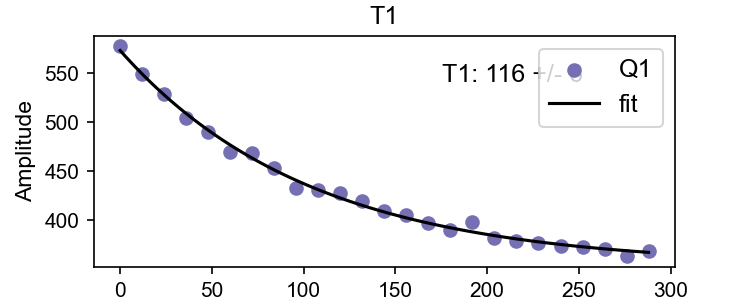

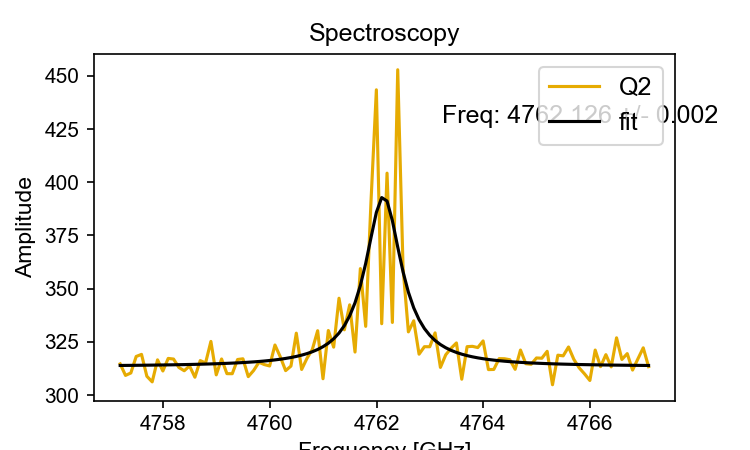

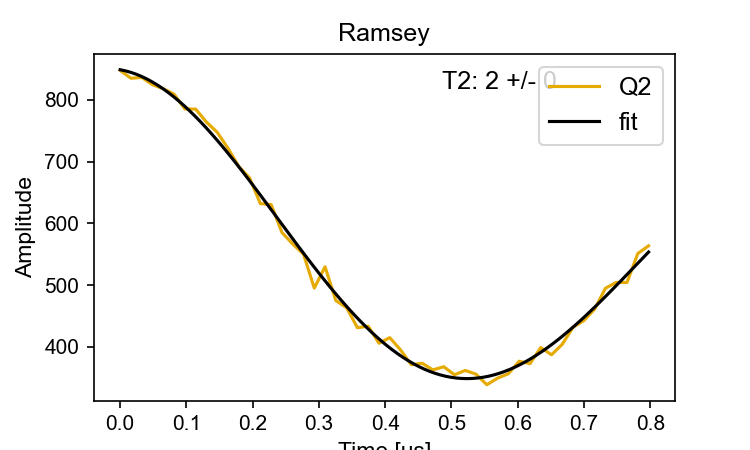

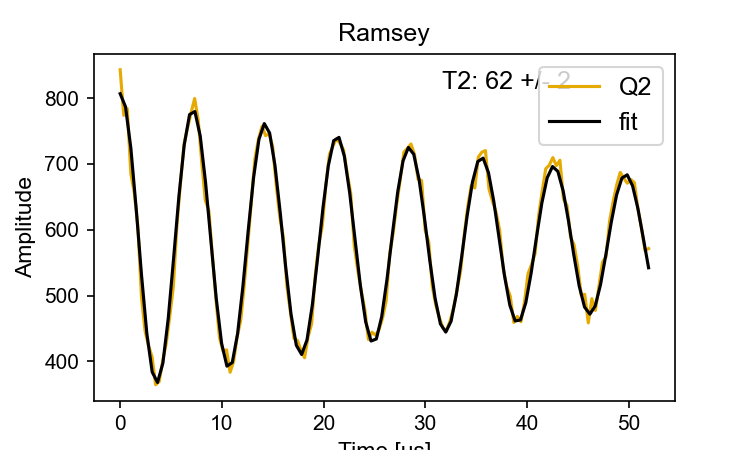

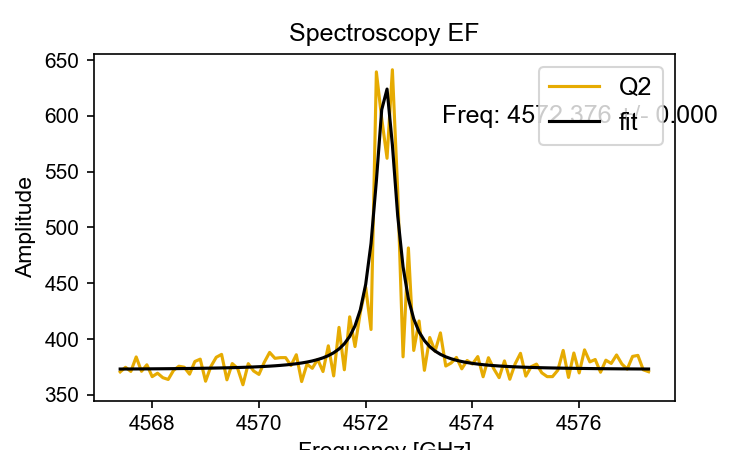

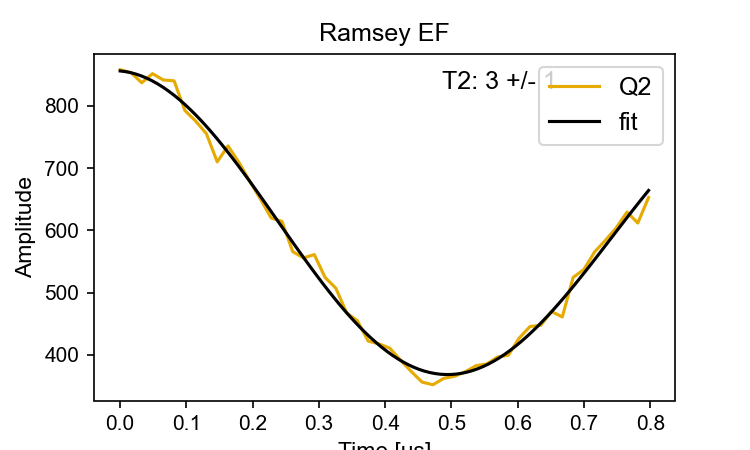

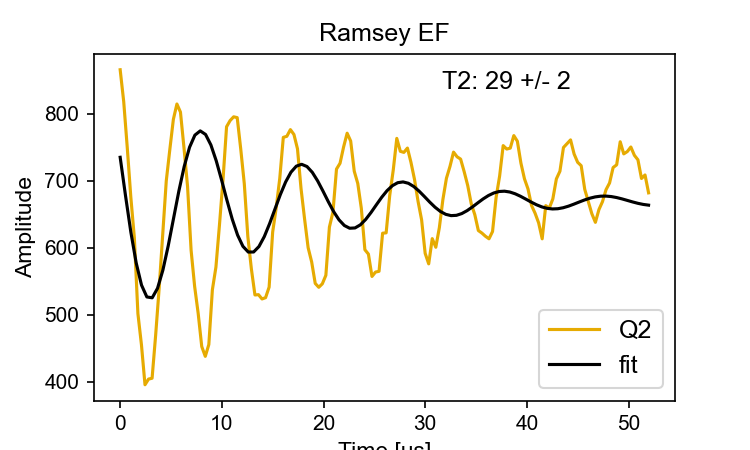

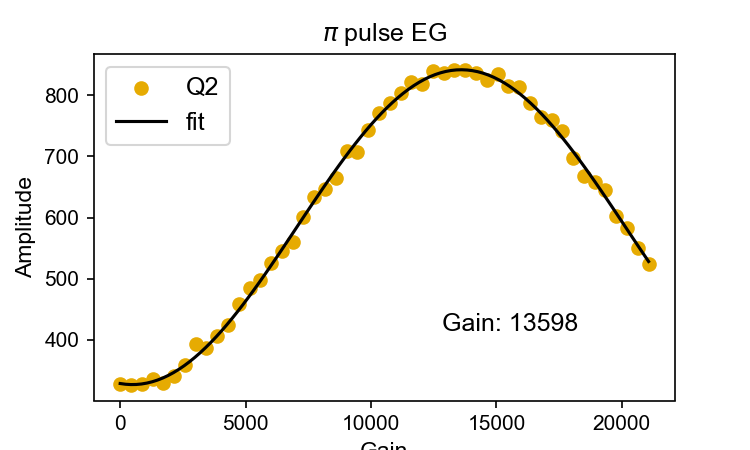

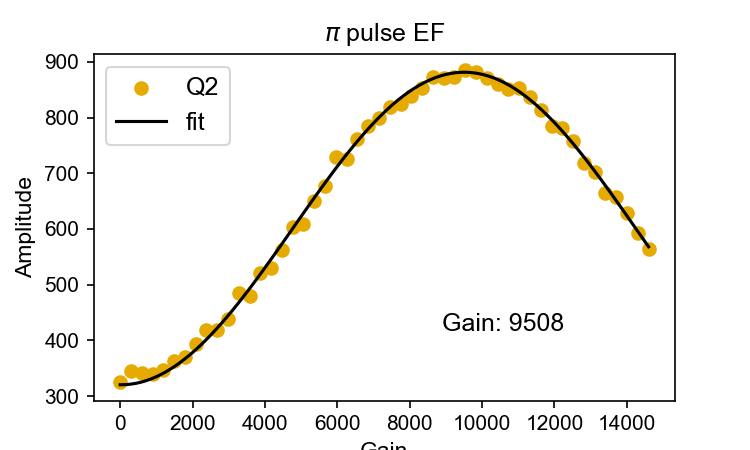

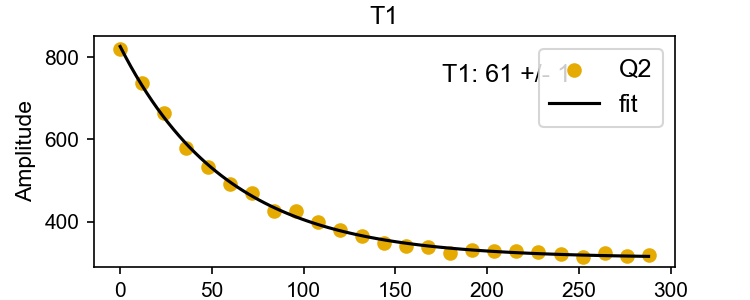

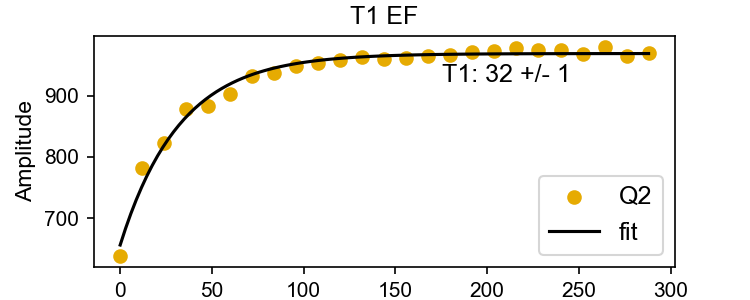

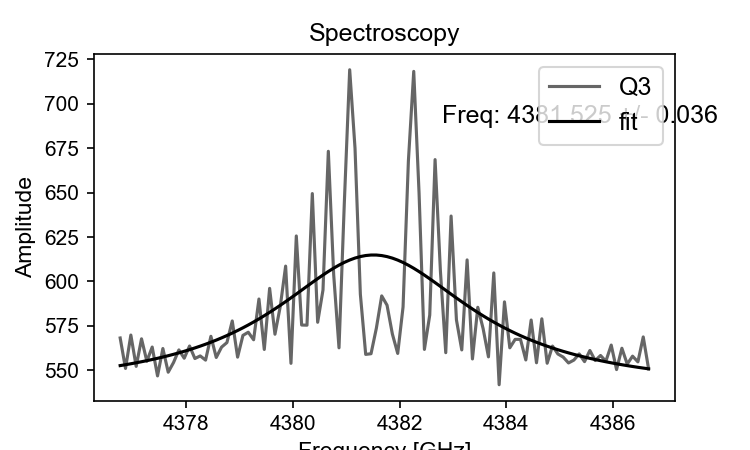

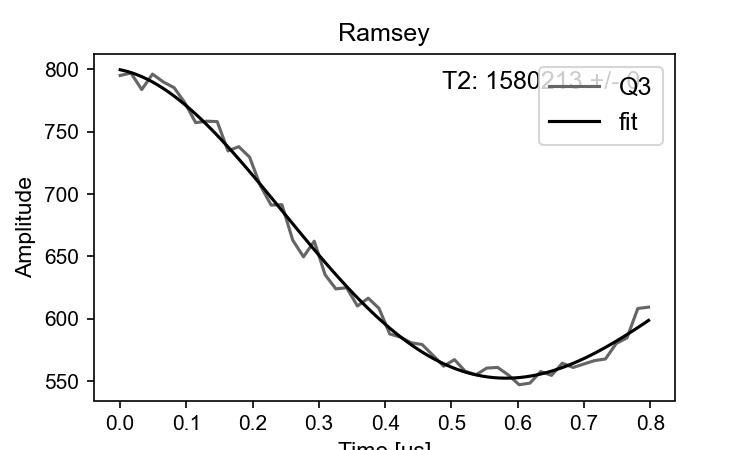

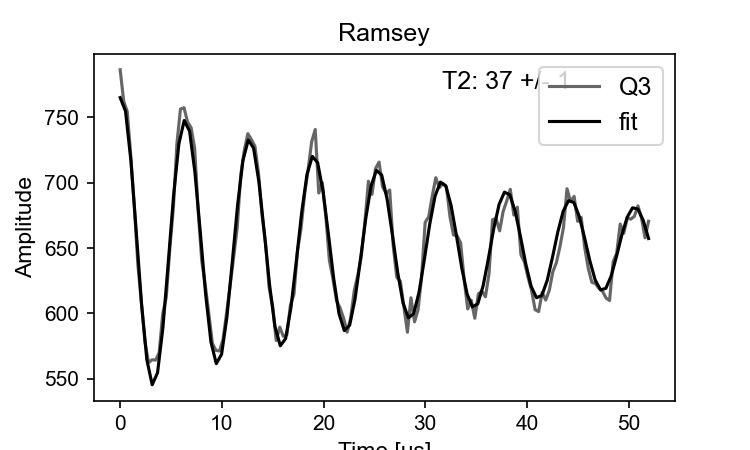

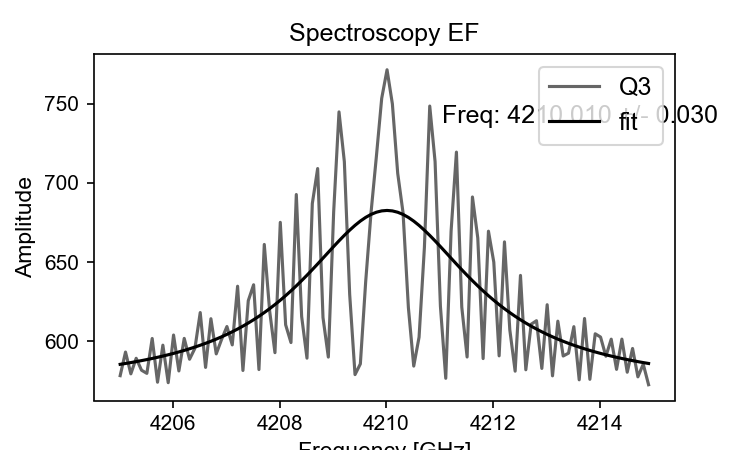

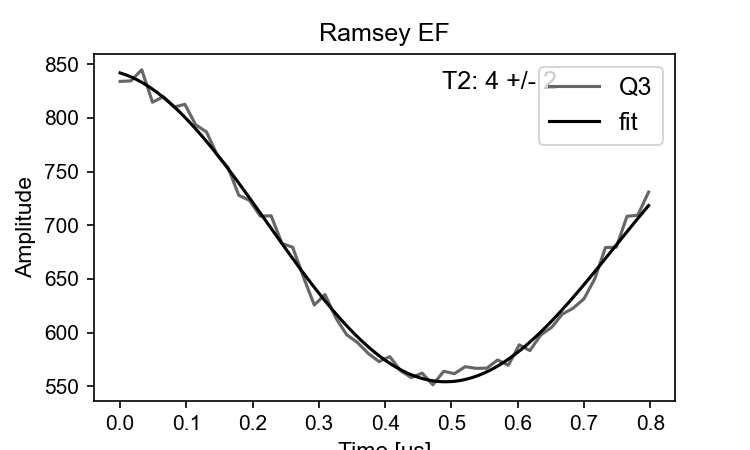

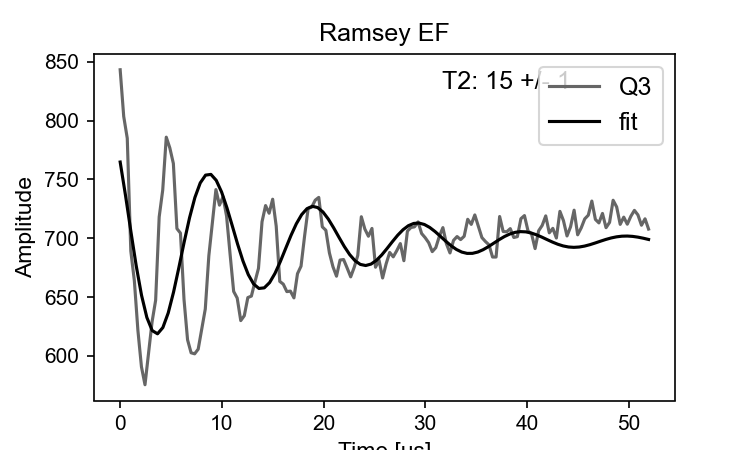

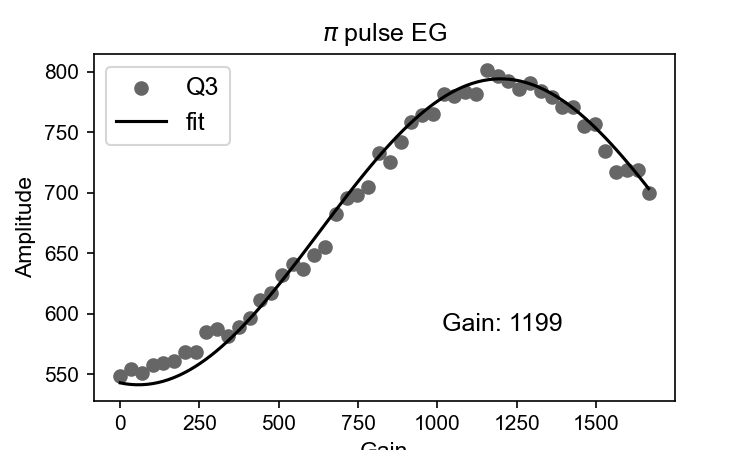

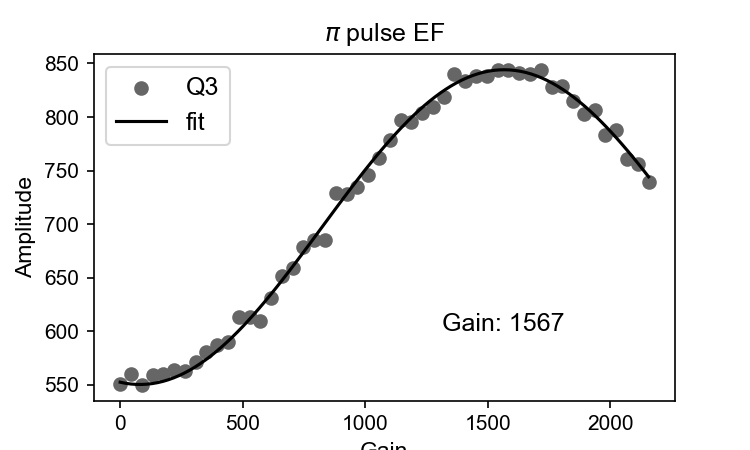

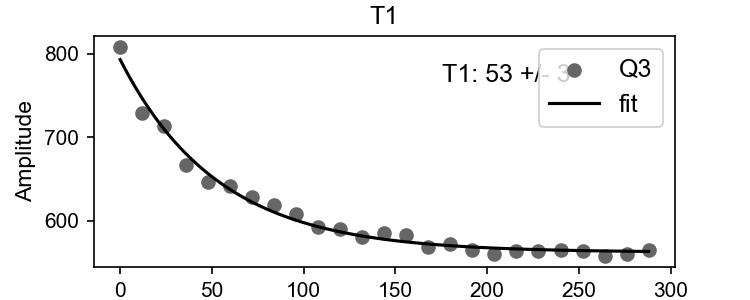

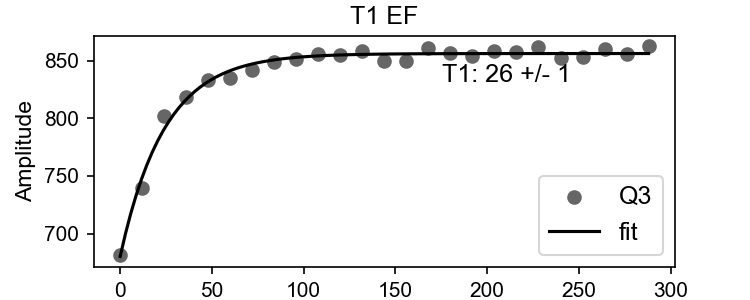

In [274]:
mono.measure_all(debug=True, save=False)

In [152]:
mono.monitor_all(debug=False, save=False)

TypeError: monitor_all() got an unexpected keyword argument 'qubits_test'

Qubit test 2, Qubit ZZ 3
spectro GE
qspec.cfg.expt {'start': 4742.195276919517, 'step': 0.4, 'expts': 100, 'reps': 100, 'rounds': 10, 'length': 1, 'gain': 150, 'pulse_type': 'const', 'qubits': [2, 3], 'checkZZ': True, 'checkEF': False, 'pulseB': True}


  0%|          | 0/10 [00:00<?, ?it/s]

best 1 0.01918126159231763
Qubit test 2, Qubit ZZ 3
ZZ -0.5637338197984718 +/- 0.0047100762741955895
qubit test 2
qubit zz 3
[4762.014416335315, None, None, None]
[None, None, None, None]
[4762.014416335315, None, None, 4761.631543099718]
[None, None, None, None]
Qubit test 2, Qubit ZZ 3
spectro GE
freq_qb: 4761.631543099718 +/- 2.2184818508740206e-05
ZZ: -0.5637338197984718 +/- 0.0047100762741955895
qspec.cfg.expt {'start': 4552.401303477017, 'step': 0.4, 'expts': 100, 'reps': 100, 'rounds': 10, 'length': 1, 'gain': 150, 'pulse_type': 'const', 'qubits': [2, 3], 'checkZZ': True, 'checkEF': True, 'pulseB': True}


  0%|          | 0/10 [00:00<?, ?it/s]

best 1 0.11780101855495653
Qubit test 2, Qubit ZZ 3
ZZ 9.954099316891188 +/- 0.08807741753654821
Qubit test 2, Qubit ZZ 3
spectro EF
freq_qb: 4582.355402793908 +/- 0.007757631479907451
ZZ: 9.954099316891188 +/- 0.08807741753654821
gain_pulse: 14337
freq_qb: 4761.631543099718
freq_qb_zz: 4381.764669681876
gain_pulse_zz: 1140


  0%|          | 0/10 [00:00<?, ?it/s]

best 0 0.04230926626731997
T2R: 14 +/- 2
Qubit test 2, Qubit ZZ 3
ramsey GE
freq_qb: 4762.123053660815 +/- 0.0022555915677101614
freq_bare: 4762.195276919517 +/- 0
ZZ: -0.07222325870225177 +/- 0.0022555915677101614
gain_pulse: 9958
freq_qb: 4582.355402793908
freq_qb_zz: 4381.764669681876
gain_pulse_zz: 1140


AssertionError: not implemented checkEF with ZZ with qubits not equal 1

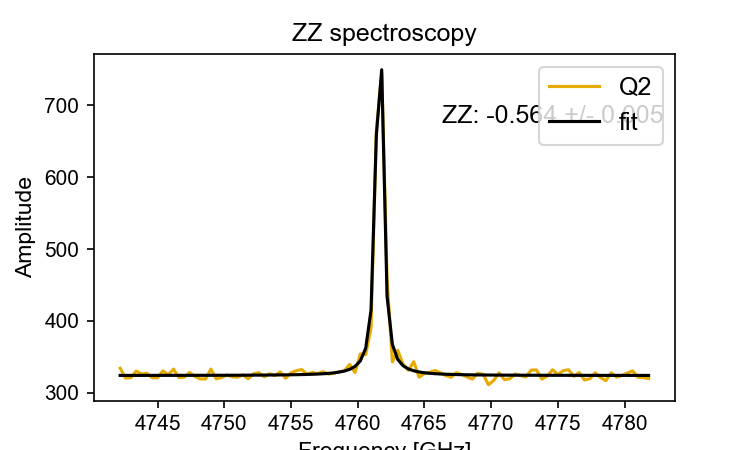

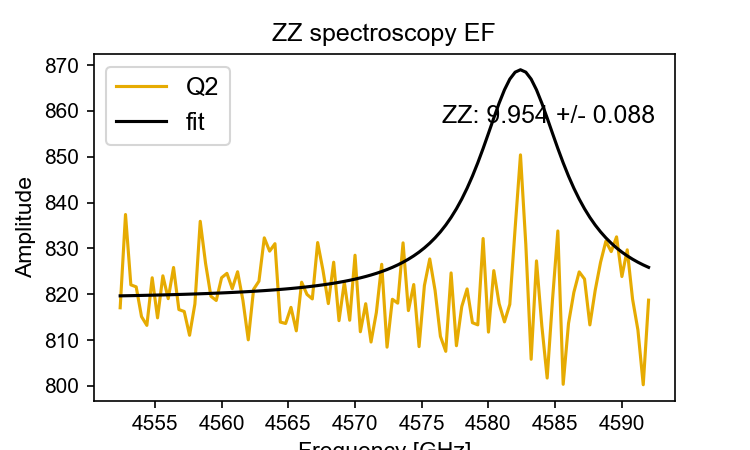

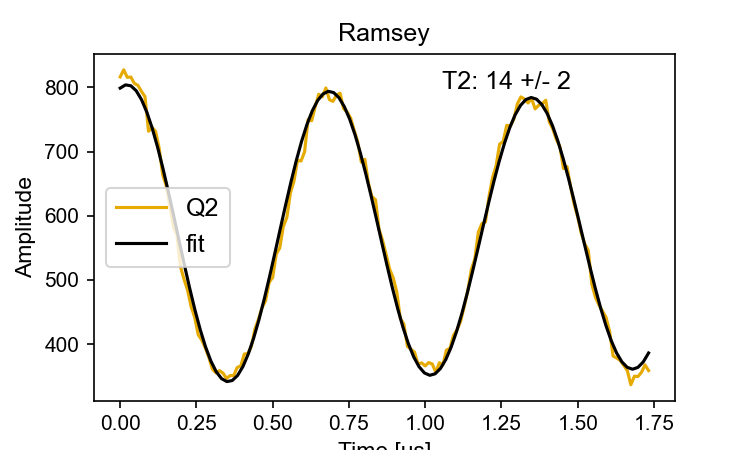

In [246]:
mono.measure_all_ZZ(debug=True, save=False, qubits_test=[2], qubits_zz = [3])

{'reps': 100, 'npts': 50, 'freq_qb': None, 'rounds': 10, 'value': None, 'value_half': None, 'stored': [], 'time': [], 'err_amp_start': 0, 'err_amp_step': 1, 'err_amp_expts': 4, 'err_amp_reps': 1000, 'err_amp_loops': 20}
2631
2320
{'start': 0, 'step': 1, 'expts': 4, 'reps': 1000, 'loops': 20, 'pulse_type': 'gauss', 'checkZZ': False, 'checkEF': False, 'qubits': [1], 'test_pi_half': True, 'post_process': 'scale', 'singleshot_reps': 15000}


  0%|          | 0/2 [00:00<?, ?it/s]

Qubit  (1)


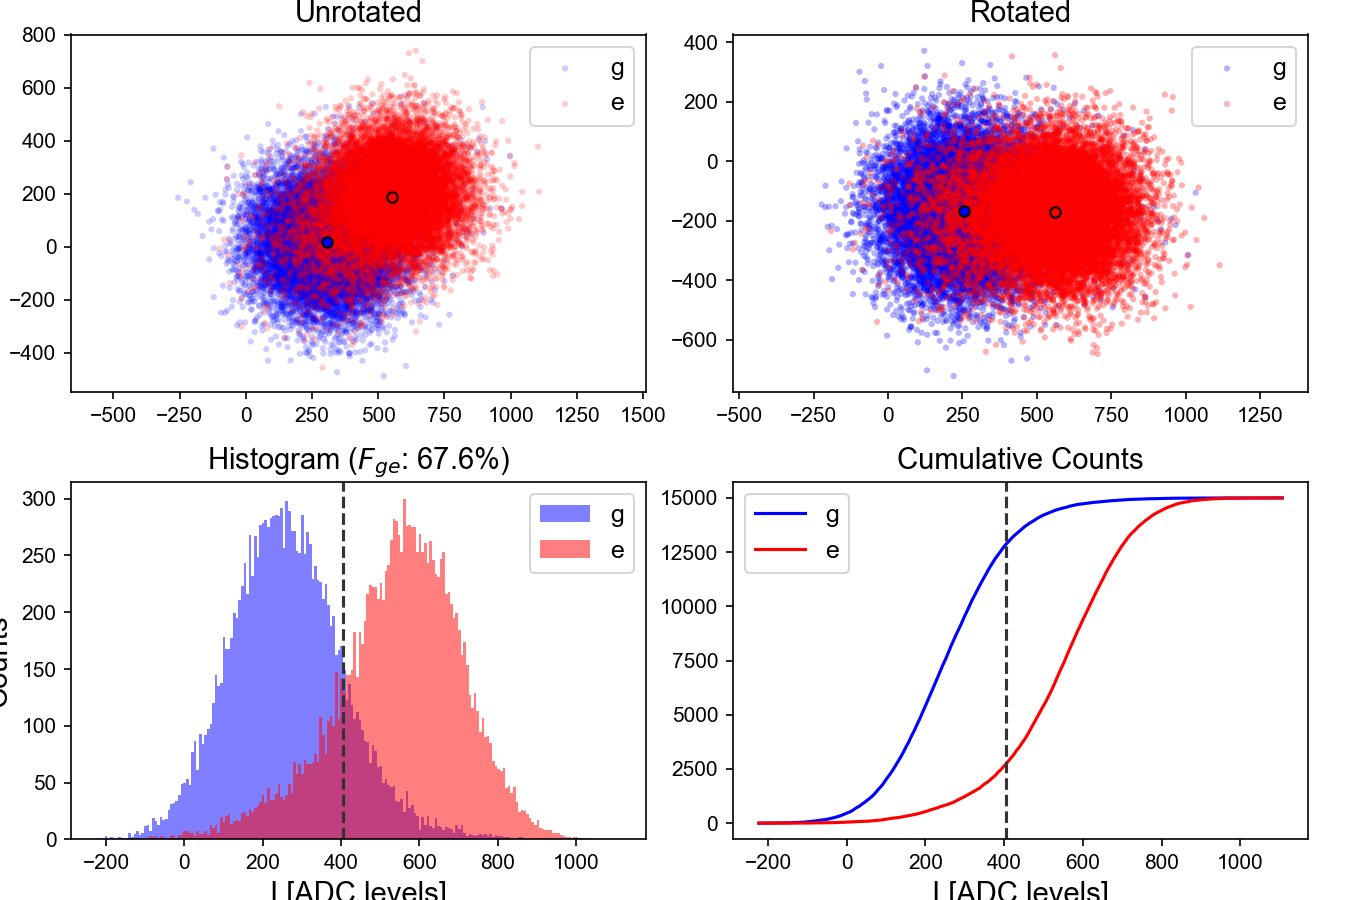

ge fidelity (%): 67.57333333333332 	 angle (deg): -36.33259757563018 	 threshold ge: 404.98188972393035
thresholds=[0, 404.98188972393035, 0, 0],
angles=[0, -36.33259757563018, 0, 0],
ge_avgs=[array([0., 0., 0., 0.]), [310.94557877604166, 20.92753904079861, 542.6153733289931, 184.5037603081597], array([0., 0., 0., 0.]), array([0., 0., 0., 0.])],
counts_calib=[[12602, 122, 2254, 22], [2590, 17, 12305, 88]]


  0%|          | 0/20 [00:00<?, ?it/s]

best 2 1.0213130429160073
Qubit 1
Gain: 2320
Angle error: 0.025759621664181203 +/- 0.0025421855312851896
New gain: 2320
x_data [0 1 2 3]
y_data [0.42802491 0.14016692 0.02143538 0.10327022]
p_fit [0.17088958 0.26758375]
y [0.17088958        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.17555973        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.16154969        nan        nan        

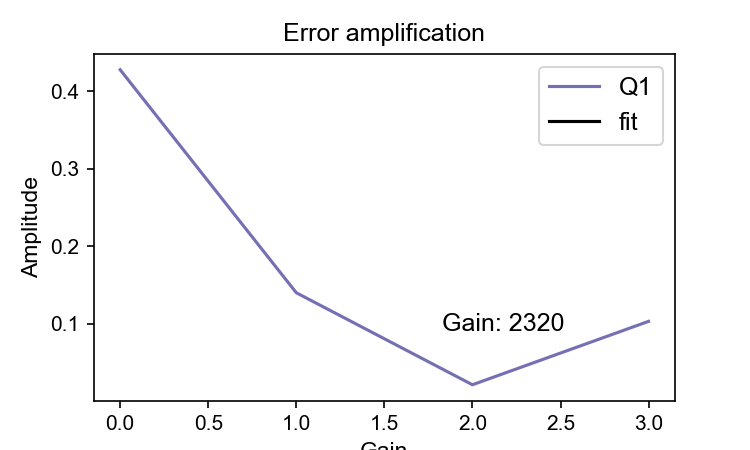

In [266]:
mono.measure_error_amplification(qubit_i=1, debug=True, save=False, pi_half=True)